Code for Preparing Training Data for X and Y dimension

In [ ]:
import numpy as np
import pandas as pd
import json
from google.colab import drive
import os

def trajectory(a_x, a_y,M_leg, M_ball, t, e, ip=0.01):
    # calculating v_leg in x, y, z
    v_l_x = a_x * ip
    v_l_y = a_y * ip
    # calculate v_ball in x, y, z
    v_b_x = v_l_x * (M_leg / (M_leg + M_ball)) * (1 + e)
    v_b_y = v_l_y * (M_leg / (M_leg + M_ball)) * (1 + e)

    # calculate the trajectory of the ball.
    x_t = v_b_x * t
    y_t = v_b_y * t
    return [x_t, y_t]

def generate_realistic_trajectory_data(num_samples, t_max, num_time_steps):
    """Generate realistic trajectory data."""
    # realistic acceleration ranges
    ax = np.random.uniform(0, 2000, num_samples)
    ay = np.random.uniform(0, 2000, num_samples)

    t = np.linspace(0, t_max, num_time_steps)

    data = []
    penalty_kick_dist = 11
    actual_goal_height = 2.4
    actual_goal_length = 7.3
    actual_goal_width = 3.0
    goal_W_bound = penalty_kick_dist + actual_goal_width
    goal_L_bound = actual_goal_length/2;
    goal_H_bound = actual_goal_height;

    for i in range(num_samples):
        scored = False
        last_x, last_y= 0, 0
        for time in t:
            if not scored:
                x_t, y_t= trajectory(ax[i], ay[i], 9, 0.3, time, 0.7, 0.01)
                in_goal = (y_t >= -goal_L_bound) and (y_t <= goal_L_bound) and (x_t >= penalty_kick_dist) and (x_t <= goal_W_bound)
                if in_goal:
                    scored = True
                    last_x, last_y = x_t, y_t
            else:
                x_t, y_t = last_x, last_y

            data.append({'ax': ax[i], 'ay': ay[i], 'time': time, 'x': x_t, 'y': y_t, 'in_goal': in_goal})

    return data

def convert_bool(data):
    for d in data:
        d['in_goal'] = bool(d['in_goal'])
    return data
#path for retriving and stroing files in my google drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/data_files/13_numsteps_data'

# check if the directory exists, and if not, create it
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

num_samples = 100
t_max = 10
num_time_steps = 13

for i in range(1, 21):  # looping through 20 iterations
    data = generate_realistic_trajectory_data(num_samples, t_max, num_time_steps)
    data = convert_bool(data)

    # define file path with unique name for each iteration, including the Google Drive directory
    file_path = os.path.join(drive_path, f'realistic_trajectory_data_{i}.json')

    # save the data to a JSON file
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

    # print success message for each file
    print(f"Data has been successfully saved to {file_path}.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_1.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_2.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_3.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_4.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_5.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_6.json.
Data has been successfully saved to /content/drive/MyDrive/data_files/13_numsteps_data/realistic_trajectory_data_7.json.
Data has been successful

Pre-process data for training the model in X dimension

In [ ]:
import numpy as np
import json
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l2
import os

# specify the new directory path
data_directory = '/content/drive/MyDrive/data_files/13_numsteps_data'
file_names = [f'realistic_trajectory_data_{i}.json' for i in range(1, 21)]
trajectories = []
initial_accs = []
in_goal = []

# load and combine data from all files
for file_name in file_names:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as file:
        data = json.load(file)
        trajectories.extend([[point['x']] for point in data])
        initial_accs.extend([[point['ax']] for point in data])
        in_goal.extend([1 if point['in_goal'] else 0 for point in data])

# parameters
num_timesteps = 13
X_train_pos = []
X_train_acc = []
y_train = []
y_train_goal = []

for i in range(len(trajectories) - num_timesteps):
    X_train_pos.append(trajectories[i:i+num_timesteps])
    X_train_acc.append(initial_accs[i])
    y_train.append(trajectories[i + num_timesteps])
    y_train_goal.append(in_goal[i + num_timesteps])

X_train_pos = np.array(X_train_pos)
X_train_acc = np.array(X_train_acc)
y_train = np.array(y_train)
y_train_goal = np.array(y_train_goal)

Train the model in X-Dimension

In [ ]:
from keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Reshape
from keras.models import Model
from keras.regularizers import l2

input_pos = Input(shape=(num_timesteps, 1))
input_acc = Input(shape=(1,))

# lSTM layers for trajectory
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(input_pos)
x = Dropout(0.2)(x)
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = LSTM(64, kernel_regularizer=l2(0.01))(x)

reshaped_acc = Reshape((1,))(input_acc)
combined = Concatenate(axis=-1)([x, reshaped_acc])
output_pos = Dense(1, activation='linear', name='position')(combined)
output_goal = Dense(1, activation='sigmoid', name='goal')(combined)

model = Model(inputs=[input_pos, input_acc], outputs=[output_pos, output_goal])

# compile the model
model.compile(optimizer='adam', loss={'position': 'mean_squared_error', 'goal': 'binary_crossentropy'},
              loss_weights={'position': 1.0, 'goal': 0.1})

# train the model
model.fit([X_train_pos, X_train_acc], [y_train, y_train_goal], epochs=200, batch_size=64, validation_split=0.2)
# save the model
model.save('x_position_goal_model.keras')

Epoch 1/200
325/325 [==============================] - 21s 50ms/step - loss: 5464.3638 - position_loss: 5449.0444 - goal_loss: 105.8486 - val_loss: 4315.6797 - val_position_loss: 4310.3262 - val_goal_loss: 0.2285
Epoch 2/200
325/325 [==============================] - 15s 46ms/step - loss: 3508.3484 - position_loss: 3502.7563 - goal_loss: 0.1234 - val_loss: 3011.5295 - val_position_loss: 3005.8843 - val_goal_loss: 0.1500
Epoch 3/200
325/325 [==============================] - 15s 46ms/step - loss: 2482.0244 - position_loss: 2476.4346 - goal_loss: 0.1012 - val_loss: 2195.3157 - val_position_loss: 2189.7654 - val_goal_loss: 0.1270
Epoch 4/200
325/325 [==============================] - 15s 46ms/step - loss: 1816.9688 - position_loss: 1811.4948 - goal_loss: 0.0925 - val_loss: 1641.4940 - val_position_loss: 1636.0629 - val_goal_loss: 0.1139
Epoch 5/200
325/325 [==============================] - 15s 47ms/step - loss: 1355.1683 - position_loss: 1349.8153 - goal_loss: 0.0892 - val_loss: 1266.239

Pre-processing data for Y-Dimension

In [ ]:
import numpy as np
import json
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l2
import os

# specify the new directory path
data_directory = '/content/drive/MyDrive/data_files/13_numsteps_data'
file_names = [f'realistic_trajectory_data_{i}.json' for i in range(1, 21)]  # Generates file names from 1 to 20

# initialize lists to store combined data
trajectories = []
initial_accs = []
in_goal = []

# load and combine data from all files
for file_name in file_names:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as file:
        data = json.load(file)
        trajectories.extend([[point['y']] for point in data])
        initial_accs.extend([[point['ay']] for point in data])
        in_goal.extend([1 if point['in_goal'] else 0 for point in data])

# parameters
num_timesteps = 13
X_train_pos = []
X_train_acc = []
y_train = []
y_train_goal = []

for i in range(len(trajectories) - num_timesteps):
    X_train_pos.append(trajectories[i:i+num_timesteps])
    X_train_acc.append(initial_accs[i])
    y_train.append(trajectories[i + num_timesteps])
    y_train_goal.append(in_goal[i + num_timesteps])

X_train_pos = np.array(X_train_pos)
X_train_acc = np.array(X_train_acc)
y_train = np.array(y_train)
y_train_goal = np.array(y_train_goal)

Training the model in Y-Dimension


In [ ]:
from keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Reshape
from keras.models import Model
from keras.regularizers import l2

# define the LSTM model
input_pos = Input(shape=(num_timesteps, 1))  # Only 1 feature per timestep (x position)
input_acc = Input(shape=(1,))  # Only 1 feature for acceleration (ax), reshaped later

# lSTM layers for trajectory
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(input_pos)
x = Dropout(0.2)(x)
x = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = Dropout(0.2)(x)
x = LSTM(64, kernel_regularizer=l2(0.01))(x)

# reshape acceleration input to match the dimensions needed for Concatenate
reshaped_acc = Reshape((1,))(input_acc)
combined = Concatenate(axis=-1)([x, reshaped_acc])

# output layers
output_pos = Dense(1, activation='linear', name='position')(combined)  # Predicts x position
output_goal = Dense(1, activation='sigmoid', name='goal')(combined)  # Predicts goal status

model = Model(inputs=[input_pos, input_acc], outputs=[output_pos, output_goal])

# compile the model
model.compile(optimizer='adam', loss={'position': 'mean_squared_error', 'goal': 'binary_crossentropy'},
              loss_weights={'position': 1.0, 'goal': 0.1})

# train the model
model.fit([X_train_pos, X_train_acc], [y_train, y_train_goal], epochs=200, batch_size=64, validation_split=0.2)
model.save('y_position_goal_model.keras')

Epoch 1/200


KeyboardInterrupt: 

Predicting the positions in X and Y dimensions using the model

In [ ]:
import numpy as np
import json
from keras.models import load_model

# load the previously saved model
model_x = load_model('/content/drive/MyDrive/ML_Capstone_Models/x_position_goal_model-2.keras')
model_y = load_model('/content/drive/MyDrive/ML_Capstone_Models/y_position_goal_model-2.keras')

# function to generate predictions recursively
def generate_predictions(initial_position, initial_acceleration, num_timesteps, num_predictions, model):
    # Start with the initial position repeated to fill the time steps
    current_position = np.full((num_timesteps, 1), initial_position)  # Shape (num_timesteps, 1)
    initial_acceleration = np.array([initial_acceleration])  # Shape (1,)

    predictions = []

    for _ in range(num_predictions):
        input_position = current_position.reshape(1, num_timesteps, 1)
        input_acceleration = initial_acceleration.reshape(1, 1)

        # predict the next position
        predicted_position = model.predict([input_position, input_acceleration])

        # check the type of predicted_position and ensure it's an np.array
        if isinstance(predicted_position, list):
            predicted_position = np.array(predicted_position[0])  # assuming the list contains one array
        else:
            predicted_position = np.array(predicted_position)

        # append the predicted position to the output
        predictions.append(predicted_position.flatten().tolist())

        # update the current position sequence
        current_position = np.vstack((current_position[1:], predicted_position))

    return predictions


# load initial conditions from JSON file
with open('/content/drive/MyDrive/data_files/Initial_data_fed_for_predictions/data_used_for_prediction.json', 'r') as file:
    data = json.load(file)
    initial_data = data[26]  # Take the first entry

# extract initial conditions
initial_position_x = initial_data['x']  # Starting x
print(initial_position_x)
initial_acceleration_x = initial_data['ax']  # Starting ax
print(initial_acceleration_x)
initial_position_y = initial_data['y']  # Starting x
print(initial_position_y)
initial_acceleration_y = initial_data['ay']  # Starting ax
print(initial_acceleration_y)
num_timesteps = 13
num_predictions = 12

predicted_positions_x = generate_predictions(initial_position_x, initial_acceleration_x, num_timesteps, num_predictions, model_x)
predicted_positions_y = generate_predictions(initial_position_y, initial_acceleration_y, num_timesteps, num_predictions, model_y)

# goal boundary conditions
goal_x = [11, 14]  # x bounds for the goal
goal_y = [-3.65, 3.65]  # y bounds for the goal
in_goal = False
# initialize data structure
predictions_data = []
predictions_data = [{'position': 0, 'x': initial_position_x, 'y': initial_position_y, 'in_goal': False}]

# process x positions
x_data = []
for i, x in enumerate(predicted_positions_x, start=1):
    if len(x) == 1:
        x_val = x[0]  # assume each list contains exactly one element
        in_goal_x = goal_x[0] <= x_val <= goal_x[1]
        x_data.append((i, x_val, in_goal_x))

# process y positions
y_data = []
for i, y in enumerate(predicted_positions_y, start=1):
    # extract the single element from the list `y`
    if len(y) == 1:
        y_val = y[0]
        in_goal_y = goal_y[0] <= y_val <= goal_y[1]
        y_data.append((i, y_val, in_goal_y))

# combine x and y data
for (xi, x, in_goal_x), (yi, y, in_goal_y) in zip(x_data, y_data):
    assert xi == yi  # Ensure indices match
    in_goal = in_goal_x and in_goal_y
    predictions_data.append({'position': xi, 'x': x, 'y': y, 'in_goal': in_goal})

# save to JSON file
with open('/content/drive/MyDrive/data_files/Predicted_datafiles_trainingdata/predicted_positions.json', 'w') as json_file:
    json.dump(predictions_data, json_file, indent=4)

print("Predictions saved.")

0.0
1670.6610190153156
0.0
945.0876264295691
1/1 [==============================] - 0s 27ms/step
Predictions saved.


Plotting the Predicted data aganist the Actual data from
Physics Model

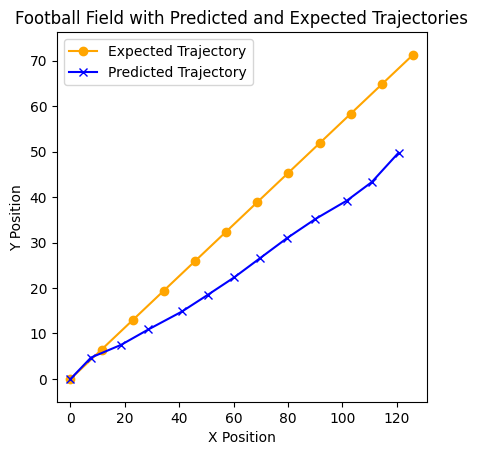

In [ ]:
import matplotlib.pyplot as plt
import json

# load predicted trajectory data
predicted_positions_path = '/content/drive/MyDrive/data_files/Predicted_datafiles_trainingdata/predicted_positions.json'
with open(predicted_positions_path, 'r') as file:
    predicted_data = json.load(file)
    predicted_x_positions = [entry['x'] for entry in predicted_data]
    predicted_y_positions = [entry['y'] for entry in predicted_data]
    predicted_in_goal = [entry['in_goal'] for entry in predicted_data]

# load expected trajectory data, first 10 positions only
expected_data_path = '/content/drive/MyDrive/data_files/Initial_data_fed_for_predictions/data_used_for_prediction.json'
with open(expected_data_path, 'r') as file:
    expected_data = json.load(file)
    x_expected = [point['x'] for point in expected_data[26:38]]
    y_expected = [point['y'] for point in expected_data[26:38]]
    expected_in_goal = [point.get('in_goal', False) for point in expected_data[26:38]]  # Assuming 'in_goal' is included in data

# determine if any "in goal" is true
predicted_in_goal_status = "True" if any(predicted_in_goal) else "False"
expected_in_goal_status = "True" if any(expected_in_goal) else "False"
fig, ax = plt.subplots()

# plotting the expected trajectory
ax.plot(x_expected, y_expected, label='Expected Trajectory', marker='o', linestyle='-', color='orange')

# plotting the predicted trajectory
ax.plot(predicted_x_positions, predicted_y_positions, label='Predicted Trajectory', marker='x', linestyle='-', color='blue')

# setting the axes limits and aspect ratio
x_min = min(x_expected + predicted_x_positions) - 5
x_max = max(x_expected + predicted_x_positions) + 5
y_min = min(y_expected + predicted_y_positions) - 5
y_max = max(y_expected + predicted_y_positions) + 5

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect(abs(x_max-x_min)/abs(y_max-y_min))

# adding labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Football Field with Predicted and Expected Trajectories')
ax.legend()
plt.show()


Extract the ax and ay from filtered accelerometer data

In [ ]:
import pandas as pd

# load the CSV file
df = pd.read_csv('/content/drive/MyDrive/data_files/filtered_acc_data/filtered_accelerations.csv')

# find the row with the maximum value in the 'Filtered X' column
max_row = df[df['Filtered X'] == df['Filtered X'].max()]

# extract the maximum x and corresponding y value
ax = max_row['Filtered X'].iloc[0]
ay = max_row['Filtered Y'].iloc[0]

print("Maximum value in x column:", ax)
print("Corresponding value in y column when x is max:", ay)

# prepare data to save, including a static 'in_goal' column
results = pd.DataFrame({
    'ax': [ax],
    'ay': [ay],
    'in_goal': [True]  # Add 'in_goal' column with the value True
})

# save the results to a new CSV file
results.to_csv('/content/drive/MyDrive/data_files/Extracted_acc_filtered_data/initial_acc_from_actual_soccer_trials.csv', index=False)
print("Results saved to initial_acc_from_actual_soccer_trials.csv")


Maximum value in x column: 9.897143714491104
Corresponding value in y column when x is max: 3.200573950646076
Results saved to initial_acc_from_actual_soccer_trials.csv


Feeding the ax and ay from accelerometer to the model

In [ ]:
import numpy as np
import json
from keras.models import load_model
import csv

# load the previously saved model
model_x = load_model('/content/drive/MyDrive/ML_Capstone_Models/x_position_goal_model_30_timesteps.keras')
model_y = load_model('/content/drive/MyDrive/ML_Capstone_Models/y_position_goal_model_30_timesteps.keras')
num_timesteps = 30
num_predictions = 60

actual_data_path = '/content/drive/MyDrive/data_files/Extracted_acc_filtered_data/initial_acc_from_actual_soccer_trials.csv'
with open(actual_data_path, 'r') as file:
    csv_reader = csv.DictReader(file)
    actual_ax = []
    actual_ay = []
    for row in csv_reader:
        actual_ax.append(float(row['ax']))
        actual_ay.append(float(row['ay']))

print(actual_ax)
print(actual_ay)

# use model to make predictions
predicted_positions_x = generate_predictions(0, actual_ax, num_timesteps, num_predictions, model_x)
predicted_positions_y = generate_predictions(0, actual_ay, num_timesteps, num_predictions, model_y)

# goal boundary conditions
goal_x = [11, 14]  # x bounds for the goal
goal_y = [-3.65, 3.65]  # y bounds for the goal

# initialize 'in_goal' to false
in_goal = False
# initialize data structure
predictions_data = []
predictions_data = [{'position': 0, 'x': 0, 'y': 0, 'in_goal': False}]

# process x positions
x_data = []
for i, x in enumerate(predicted_positions_x, start=1):
    # extract the single element from the list `x`
    if len(x) == 1:
        x_val = x[0]  # Assume each list contains exactly one element
        in_goal_x = goal_x[0] <= x_val <= goal_x[1]
        x_data.append((i, x_val, in_goal_x))

# process y positions
y_data = []
for i, y in enumerate(predicted_positions_y, start=1):
    # extract the single element from the list `y`
    if len(y) == 1:
        y_val = y[0]
        in_goal_y = goal_y[0] <= y_val <= goal_y[1]
        y_data.append((i, y_val, in_goal_y))

# combine x and y data
for (xi, x, in_goal_x), (yi, y, in_goal_y) in zip(x_data, y_data):
    assert xi == yi  # Ensure indices match
    in_goal = in_goal_x and in_goal_y
    predictions_data.append({'position': xi, 'x': x, 'y': y, 'in_goal': in_goal})


# save the predicted positions to a JSON file
with open('/content/drive/MyDrive/data_files/Predicted_datafiles_filtereddata/data_files_actual_trials_predictions.json', 'w') as json_file:
    json.dump(predictions_data, json_file, indent=4)

print("Predictions saved to /content/drive/MyDrive/data_files/Predicted_datafiles_filtereddata/data_files_actual_trials_predictions.json")


[9.897143714491104]
[3.200573950646076]
1/1 [==============================] - 0s 41ms/step
Predictions saved to /content/drive/MyDrive/data_files/Predicted_datafiles_filtereddata/data_files_actual_trials_predictions.json


Plot the Actual data Vs Predicted data for accelerometer

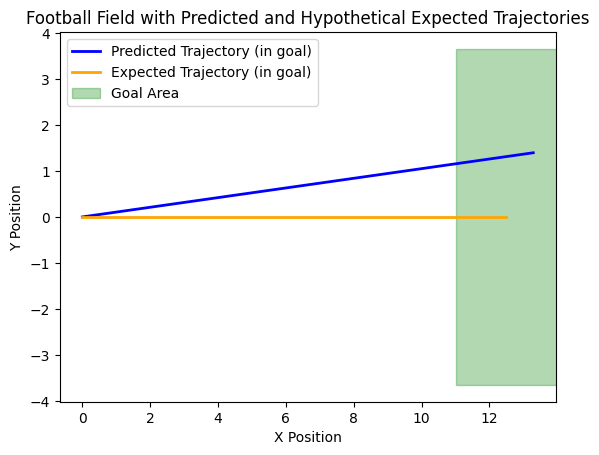

In [ ]:
import matplotlib.pyplot as plt
import json

# load predicted trajectory data
predicted_positions_path = '/content/drive/MyDrive/data_files/Predicted_datafiles_filtereddata/data_files_actual_trials_predictions.json'
with open(predicted_positions_path, 'r') as file:
    predicted_data = json.load(file)
    predicted_x_positions = [entry['x'] for entry in predicted_data]
    predicted_y_positions = [entry['y'] for entry in predicted_data]
    predicted_in_goal = [entry['in_goal'] for entry in predicted_data]

fig, ax = plt.subplots()

# function to find the first in-goal position
def find_first_in_goal(x_positions, y_positions, in_goal_flags):
    for i, flag in enumerate(in_goal_flags):
        if flag:
            return x_positions[i], y_positions[i]
    return None, None

# predicted trajectory
pred_x_end, pred_y_end = find_first_in_goal(predicted_x_positions, predicted_y_positions, predicted_in_goal)
if pred_x_end is not None:
    ax.plot([predicted_x_positions[0], pred_x_end], [predicted_y_positions[0], pred_y_end], 'blue', label='Predicted Trajectory (in goal)', linewidth=2)
else:
    ax.plot([predicted_x_positions[0], predicted_x_positions[0] - 5], [predicted_y_positions[0], predicted_y_positions[0]], 'blue', label='Predicted Trajectory (not in goal)', linestyle='--')

# expected trajectory (hypothetical)
# using a slightly different endpoint within the goal for clarity
expected_end_x = 12.5
expected_end_y = 0
ax.plot([0, expected_end_x], [0, expected_end_y], 'orange', label='Expected Trajectory (in goal)', linewidth=2)

# highlighting the goal area
goal_x = [11, 14]  # x bounds for the goal
goal_y = [-3.65, 3.65]  # y bounds for the goal
xmin_norm = (goal_x[0] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
xmax_norm = (goal_x[1] - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0])
ax.axhspan(goal_y[0], goal_y[1], xmin=xmin_norm, xmax=xmax_norm, color='green', alpha=0.3, label='Goal Area')

# adding labels and legend
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Football Field with Predicted and Hypothetical Expected Trajectories')
ax.legend()
plt.show()


Error Calculation for Trajectory

In [ ]:
import json
import numpy as np

def direction_vector(point1, point2):
    """Calculate the direction vector from point1 to point2."""
    vector = np.array([point2['x'] - point1['x'], point2['y'] - point1['y']])
    norm = np.linalg.norm(vector)
    return vector / norm if norm != 0 else np.array([0, 0])

# load the expected data from trajectory3.json
with open('/content/drive/MyDrive/data_files/ErrorCalculationData/ActualData/realistic_trajectory_data-2.json', 'r') as file:
    expected_data = json.load(file)

# load the actual data from predicted3.json
with open('/content/drive/MyDrive/data_files/ErrorCalculationData/PredictedData/predicted_realistic_trajectory_data-2.json', 'r') as file:
    actual_data = json.load(file)

# function to calculate the Euclidean distance between two direction vectors
def direction_error(v1, v2):
    return np.linalg.norm(v1 - v2)

# calculate the direction vectors and the errors
direction_errors = []
for i in range(len(actual_data) - 1):
    v1 = direction_vector(expected_data[i], expected_data[i+1])
    v2 = direction_vector(actual_data[i], actual_data[i+1])
    error = direction_error(v1, v2)
    direction_errors.append(error)

# maximum possible error for a direction vector is 2 (if they are diametrically opposed)
max_direction_error = 2
direction_errors_percent = [(error / max_direction_error) * 100 for error in direction_errors]

# calculate the maximum distance from the start point in the expected trajectory
# which will be our reference for 100% error in trajectory prediction
start_point = np.array([expected_data[0]['x'], expected_data[0]['y']])
max_distance = max(np.linalg.norm(np.array([point['x'], point['y']]) - start_point) for point in expected_data)

# calculate the trajectory prediction errors and express them as percentages of the maximum distance
trajectory_prediction_errors = [np.linalg.norm(np.array([expected['x'], expected['y']]) -
                                               np.array([actual['x'], actual['y']]))
                                for expected, actual in zip(expected_data, actual_data)]
trajectory_prediction_errors_percent = [(error / max_distance) * 100 for error in trajectory_prediction_errors]

# calculate the overall percentage errors
average_direction_error_percent = sum(direction_errors_percent) / len(direction_errors_percent)
average_trajectory_prediction_error_percent = sum(trajectory_prediction_errors_percent) / len(trajectory_prediction_errors_percent)

# print the overall percentage errors
print("Overall Direction Vector Error (% of max possible error):", average_direction_error_percent)
print("Overall Trajectory Prediction Error (% of max possible trajectory distance):", average_trajectory_prediction_error_percent)


Overall Direction Vector Error (% of max possible error): 5.900941794273418
Overall Trajectory Prediction Error (% of max possible trajectory distance): 11.358414164442962
